In [1]:
import numpy as np
import re
import os
import glob
from astropy.time import Time
from astropy.coordinates import Angle
from astropy import units
import spec_calcs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
directory = './h2c/'
h2c_files = sorted(glob.glob(os.path.join(directory,'acc_*.dat')))
n_files = len(h2c_files)

In [3]:
n_ants = np.zeros(n_files, dtype=int)
n_baselines = np.zeros(n_files, dtype=int)
max_ew = np.zeros(n_files)
mean_ew = np.zeros(n_files)
max_ns = np.zeros(n_files)
mean_ns = np.zeros(n_files)
max_len = np.zeros(n_files)
mean_len = np.zeros(n_files)
pos_dict = {}
uvw_dict = {}
dates = []

In [4]:
for f_ind, filename in enumerate(h2c_files):
    date_str = re.findall(r'\d+', os.path.basename(filename))[0]
    dates.append(Time('20' + date_str[0:2] + '-' + date_str[2:4] + '-' + date_str[4:6] + 'T00:00:00', scale='utc'))
    ant_names = np.loadtxt(filename, usecols=(0,), dtype=str)
    ant_nums = [int(re.findall(r'\d+', name)[0]) for name in ant_names]
    data = np.loadtxt(filename, usecols=(1,2,3))
    eastings = data[:, 0]
    northings = data[:, 1]
    altitudes = data[:, 2]
    pos_dict[f_ind] = np.array([eastings,northings,altitudes]).T
    n_ants[f_ind] = ant_names.shape[0]
    n_baselines[f_ind] = int(n_ants[f_ind] * (n_ants[f_ind]-1) / 2)

    uvw_array = np.zeros((n_baselines[f_ind], 3), dtype = float)
    ant1_array = np.zeros(n_baselines[f_ind], dtype = int)
    ant2_array = np.zeros(n_baselines[f_ind], dtype = int)
    bl_ind = 0
    for ind1, ant1 in enumerate(ant_nums):
        for ind2, ant2 in enumerate(ant_nums):
            if ant1 < ant2:
                ant1_array[bl_ind] = ant1
                ant2_array[bl_ind] = ant2
                uvw_array[bl_ind, :] = [eastings[ind1] - eastings[ind2], northings[ind1] - northings[ind2],
                                        altitudes[ind1] - altitudes[ind2]]
                bl_ind += 1
    uvw_dict[f_ind] = uvw_array
    max_ew[f_ind] = np.max(abs(uvw_array[:,0]))
    mean_ew[f_ind] = np.mean(abs(uvw_array[:,0]))
    max_ns[f_ind] = np.max(abs(uvw_array[:,1]))
    mean_ns[f_ind] = np.mean(abs(uvw_array[:,1]))
    max_len[f_ind] = np.max(np.linalg.norm(uvw_array, axis=1))
    mean_len[f_ind] = np.mean(np.linalg.norm(uvw_array, axis=1))

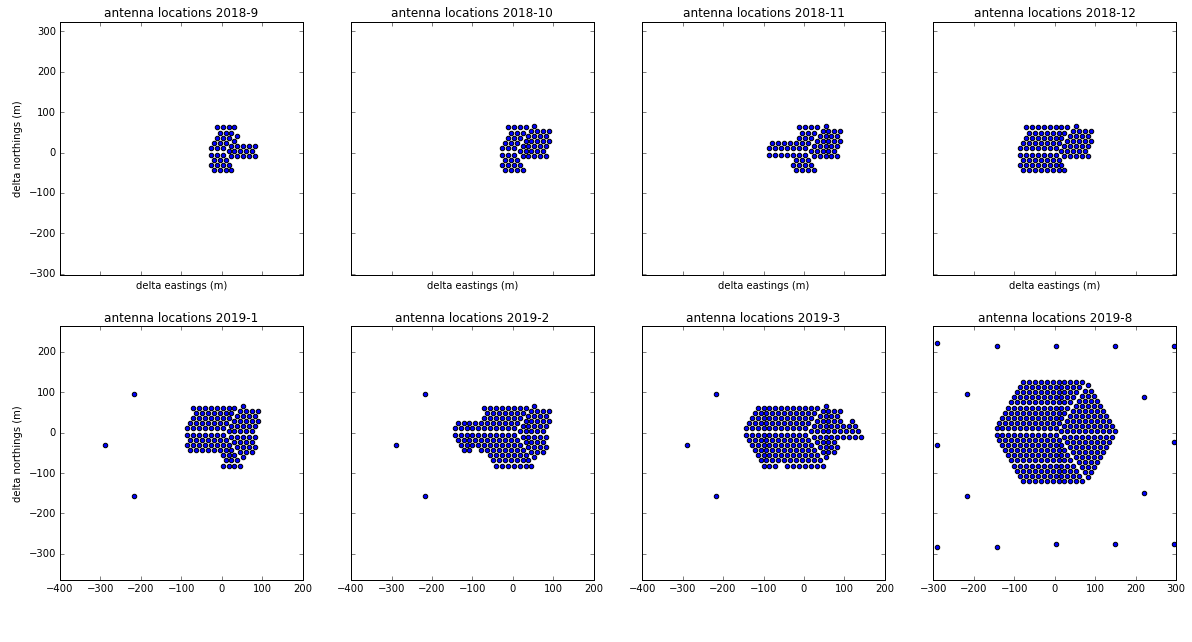

In [5]:
n_col = 4
n_row = int(np.ceil(n_files / float(n_col)))
matplotlib.rcParams['figure.figsize'] = (5*n_col,5*n_row)

array_center = np.mean(pos_dict[n_files-1], axis=0)
plot_ew = np.array([-1,1]) * np.ceil(np.max(abs(pos_dict[n_files-1][:,0] - array_center[0]), axis=0)/20)*20
plot_ns = np.array([-1,1]) * np.ceil(np.max(abs(pos_dict[n_files-1][:,1] - array_center[1]), axis=0)/20)*20

plt.figure(1)
fig, axes = plt.subplots(n_row, n_col, sharex='col', sharey='row')
for ind in range(n_files):
    row_num = int(ind % n_col)
    col_num = int(ind / n_col)
    positions = pos_dict[ind]
 
    axes[col_num, row_num].scatter(positions[:, 0] - array_center[0], positions[:, 1] - array_center[1])
    if row_num == 0:
        axes[col_num, row_num].set_ylabel("delta northings (m)")
    if col_num == 0:
        axes[col_num, row_num].set_xlabel("delta eastings (m)")
    axes[col_num, row_num].set_aspect('equal', 'datalim')
    axes[col_num, row_num].set_title('antenna locations {yr}-{mo}'.format(yr=dates[ind].datetime.year, mo=dates[ind].datetime.month))

plt.show()
plt.close()

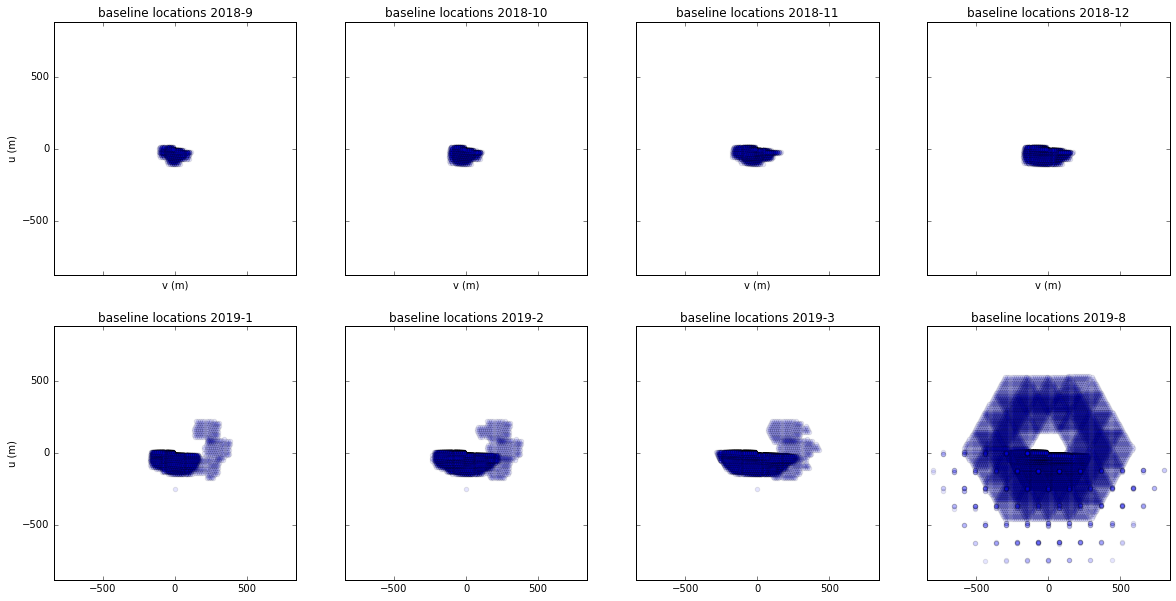

In [6]:
plot_ew = np.array([-1,1]) * np.ceil(np.max(abs(uvw_dict[n_files-1][:,0]), axis=0)/20)*20
plot_ns = np.array([-1,1]) * np.ceil(np.max(abs(uvw_dict[n_files-1][:,1]), axis=0)/20)*20
plot_range = np.array([-1,1]) * np.max([plot_ew, plot_ns])

plt.figure(1)
fig, axes = plt.subplots(n_row, n_col, sharex='col', sharey='row')
fig.set_figheight(5*n_row)
fig.set_figwidth(5*n_col)
for ind in range(n_files):
    row_num = int(ind % n_col)
    col_num = int(ind / n_col)
    uvw_array = uvw_dict[ind]
 
    axes[col_num, row_num].scatter(uvw_array[:, 0], uvw_array[:, 1], alpha=0.1)
    if row_num == 0:
        axes[col_num, row_num].set_ylabel("u (m)")
    if col_num == 0:
        axes[col_num, row_num].set_xlabel("v (m)")
    axes[col_num, row_num].set_xlim(plot_range)
    axes[col_num, row_num].set_ylim(plot_range)
    axes[col_num, row_num].set_aspect('equal')
    axes[col_num, row_num].set_title('baseline locations {yr}-{mo}'.format(yr=dates[ind].datetime.year,
                                                                           mo=dates[ind].datetime.month))

plt.show()
plt.close()

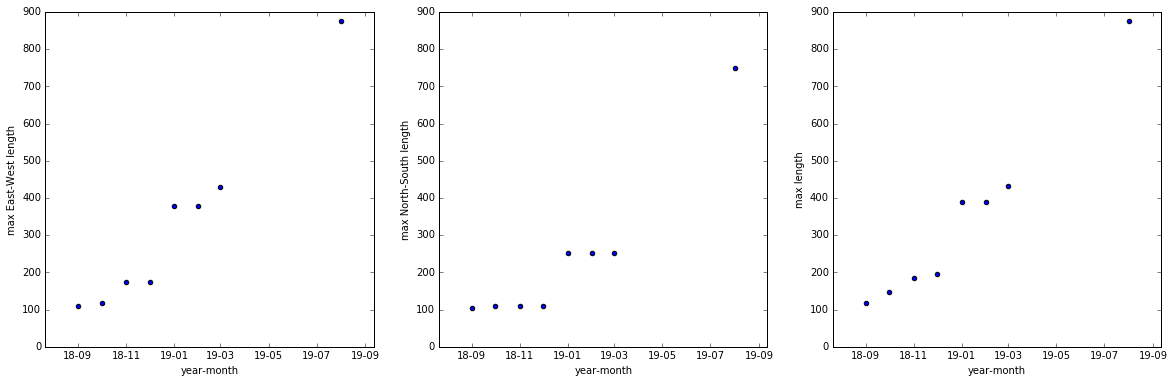

In [7]:
matplotlib.rcParams['figure.figsize'] = (20,6)
plot_dates = [date.datetime for date in dates]
month_format = mdates.DateFormatter('%y-%m')

plt.figure(1)
fig, axes = plt.subplots(1, 3)
axes[0].scatter(plot_dates, max_ew)
axes[0].set_xlabel("year-month")
axes[0].set_ylabel("max East-West length")
axes[0].set_ylim((0, 900))
axes[0].xaxis.set_major_formatter(month_format)

axes[1].scatter(plot_dates, max_ns)
axes[1].set_xlabel("year-month")
axes[1].set_ylabel("max North-South length")
axes[1].set_ylim((0, 900))
axes[1].xaxis.set_major_formatter(month_format)

axes[2].scatter(plot_dates, max_len)
axes[2].set_xlabel("year-month")
axes[2].set_ylabel("max length")
axes[2].set_ylim((0, 900))
axes[2].xaxis.set_major_formatter(month_format)

plt.show()
plt.close()

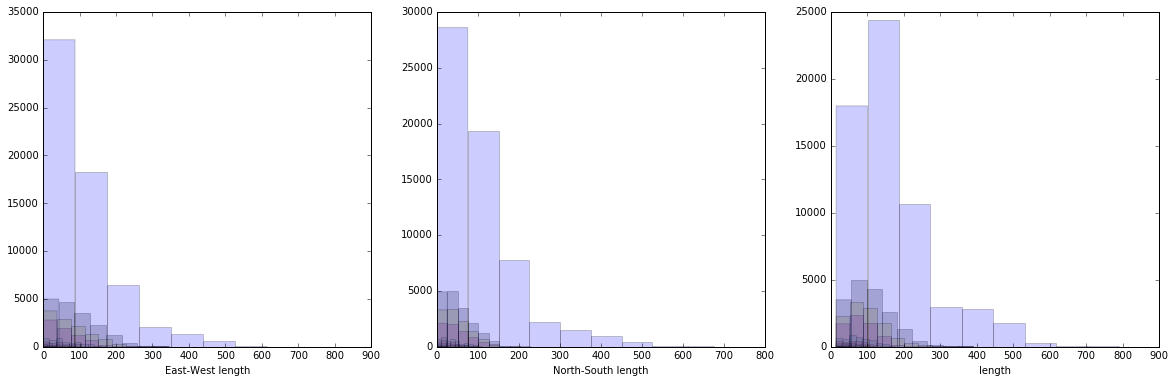

In [8]:
plt.figure(1)
plt.subplot(1, 3, 1)
for ind in range(n_files):
    uvw_array = uvw_dict[ind]
    plt.hist(abs(uvw_array[:,0]), alpha=0.2)
plt.xlabel("East-West length")

plt.subplot(1, 3, 2)
for ind in range(n_files):
    uvw_array = uvw_dict[ind]
    plt.hist(abs(uvw_array[:,1]), alpha=0.2)
plt.xlabel("North-South length")

plt.subplot(1, 3, 3)
for ind in range(n_files):
    uvw_array = uvw_dict[ind]
    plt.hist(np.linalg.norm(uvw_array, axis=1), alpha=0.2)
plt.xlabel("length")

plt.show()
plt.close()

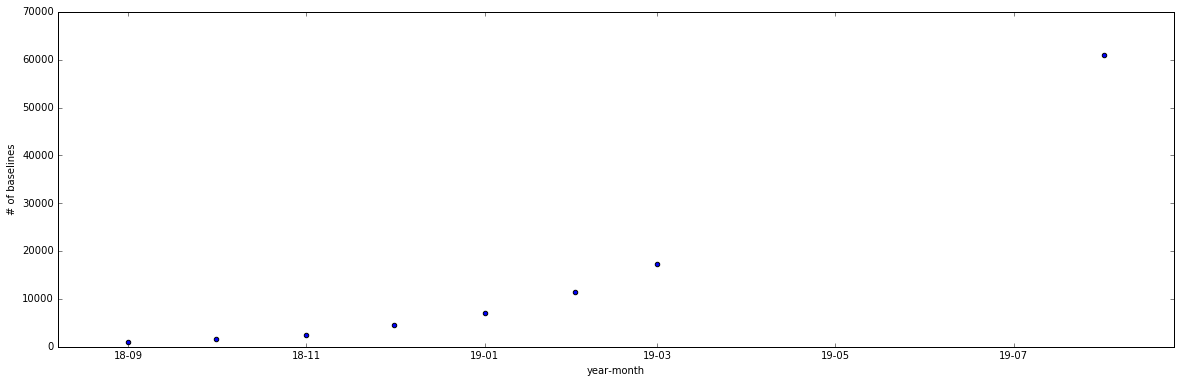

In [9]:
fig, axis = plt.subplots()
axis.scatter(plot_dates, n_baselines)
axis.set_xlabel("year-month")
axis.set_ylabel("# of baselines")
axis.set_ylim(ymin=0)
axis.xaxis.set_major_formatter(month_format)

In [10]:
max_baseline_m = [(bl * units.m) for bl in max_ew]
max_baseline_m = units.Quantity(max_baseline_m, units.m)  
params = spec_calcs.averaging_params(max_decorr=0.1, baseline=max_baseline_m,
                                     corr_FoV=Angle(90., units.degree), verbose=True)

Max resolution:
['37.6486arcmin' '35.2955arcmin' '23.5301arcmin' '23.5301arcmin'
 '10.86arcmin' '10.86arcmin' '9.57151arcmin' '4.70599arcmin']
Max integration time required to keep the decorrelation due to time integrating under max_decorr on
the longest baselines:
[ 15.01833185  14.07965203   9.38634307   9.38634307   4.33213172
   4.33213172   3.81814857   1.87725454] s
Max channel width to keep the decorrelation due to channel width under max_decorr for a 90.0 degree
correlator FoV on the longest baselines:
[ 273.78306667  256.671625    171.11441667  171.11441667   78.97588462
   78.97588462   69.60586441   34.22288333] kHz
Max integration time to keep the decorrelation due to time integrating after fringe stopping under
max_decorr for a 90.0 degree correlator FoV on the longest baselines:
[ 29.39779351  27.5603647   18.37339713  18.37339713   8.47997734
   8.47997734   7.47387556   3.67465188] s


In [11]:
max_baseline_m = [(bl * units.m) for bl in max_ew]
max_baseline_m = units.Quantity(max_baseline_m, units.m)  
params = spec_calcs.averaging_params(max_decorr=0.1, baseline=max_baseline_m,
                                     corr_FoV=Angle(10., units.degree), verbose=True)

Max resolution:
['37.6486arcmin' '35.2955arcmin' '23.5301arcmin' '23.5301arcmin'
 '10.86arcmin' '10.86arcmin' '9.57151arcmin' '4.70599arcmin']
Max integration time required to keep the decorrelation due to time integrating under max_decorr on
the longest baselines:
[ 15.01833185  14.07965203   9.38634307   9.38634307   4.33213172
   4.33213172   3.81814857   1.87725454] s
Max channel width to keep the decorrelation due to channel width under max_decorr for a 10.0 degree
correlator FoV on the longest baselines:
[ 1576.6538431   1478.11297791   985.40865194   985.40865194   454.8039932
   454.8039932    400.8441974    197.08173039] kHz
Max integration time to keep the decorrelation due to time integrating after fringe stopping under
max_decorr for a 10.0 degree correlator FoV on the longest baselines:
[ 169.29514556  158.71381476  105.80817709  105.80817709   48.83424319
   48.83424319   43.04033395   21.16147679] s


First do calculation with fringe stopping.

In [12]:
# This is the max number of channels that Jack can do 'easily'
n_channels = 4096
corr_chan_width = (250 * units.MHz) / n_channels
# Since we will integrate longer after fringe stopping, there's no need to integrate more here
corr_integration_time = .1 * units.s
# after fringe stopping, we can sum in time to longer integrations
corr_post_fringe_stop_int_time = 10 * units.s

channels_to_keep = n_channels * 3.0/4.0
obs_hrs_per_day=(12 * units.hour / units.day)
days_per_month=(30 * units.day)

In [13]:
proposed_h2c_decorrelations_90 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                              corr_FoV=Angle(90., units.degree),
                                              n_channels=n_channels, chan_width=corr_chan_width,
                                              integration_time=corr_integration_time,
                                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                              verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.00066585  0.00071024  0.00106538  0.00106538  0.00230833  0.00230833
  0.00261907  0.00532693]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
16444.74466458891 m
Decorrelation due to channel width for a 90.0 degree correlator FoV for the longest baseline
[ 0.02229325  0.02377947  0.03566921  0.03566921  0.07728328  0.07728328
  0.0876868   0.17834604]
Longest baseline for a 90.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
491.17996318720003 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s'
 '90d00m00s' '34d06m17.1197s']
Decorrelation due to time integrating after fringe stopping for a 90.0 degree correlator FoV for the
longest baseline
[ 0.03401616  0.03628399  0.05442652  0.05442652  0.11792484  0.11792484
  0.13379939  0.2721

In [14]:
proposed_h2c_decorrelations_10 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                              corr_FoV=Angle(10., units.degree),
                                              n_channels=n_channels, chan_width=corr_chan_width,
                                              integration_time=corr_integration_time,
                                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                              verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.00066585  0.00071024  0.00106538  0.00106538  0.00230833  0.00230833
  0.00261907  0.00532693]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
16444.74466458891 m
Decorrelation due to channel width for a 10.0 degree correlator FoV for the longest baseline
[ 0.00387118  0.00412926  0.00619389  0.00619389  0.0134201   0.0134201
  0.01522665  0.03096946]
Longest baseline for a 10.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
2828.5926739140245 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s'
 '90d00m00s' '34d06m17.1197s']
Decorrelation due to time integrating after fringe stopping for a 10.0 degree correlator FoV for the
longest baseline
[ 0.00590684  0.00630065  0.00945107  0.00945107  0.02047743  0.02047743
  0.02323402  0.04725

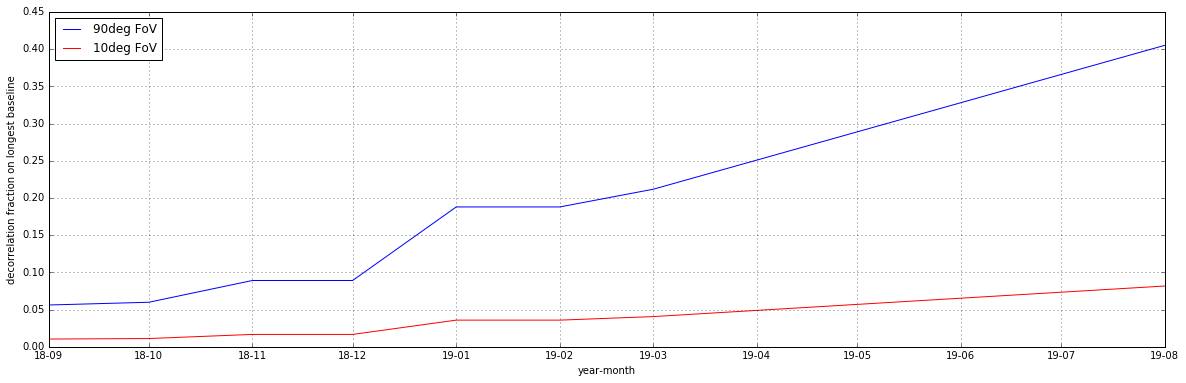

In [15]:
proposed_h2c_total_decorr_90 = proposed_h2c_decorrelations_90['post_fs_total_decorr']
proposed_h2c_total_decorr_10 = proposed_h2c_decorrelations_10['post_fs_total_decorr']

fig, axis = plt.subplots()
axis.plot(plot_dates, proposed_h2c_total_decorr_90, label='90deg FoV')
axis.plot(plot_dates, proposed_h2c_total_decorr_10, color='r', label='10deg FoV')
axis.set_xlabel("year-month")
axis.set_ylabel("decorrelation fraction on longest baseline")
axis.legend(loc=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

In [16]:
rates = spec_calcs.data_rates(integration_time=corr_integration_time,
                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                              n_antennas=n_ants, n_channels=channels_to_keep)
print('Naive (correlator internal):')
print('data rate: ', rates[0].to(units.Gbyte/units.s))
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_integration_time)
print('')
print('post fringe stopping:')
print('data rate: ', rates[1].to(units.Gbyte/units.s))
month_data_vol = (rates[1].to(units.Pbyte / units.hour) * obs_hrs_per_day * days_per_month)
print('data volume per month: ', month_data_vol)
proposed_h2c_cumulative_data_volume = np.cumsum(month_data_vol)
print('cumulative data volume per month: ', proposed_h2c_cumulative_data_volume)
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_post_fringe_stop_int_time)

Naive (correlator internal):
data rate:  [   2.21773824    3.4799616     5.02530048    8.9653248    14.2737408
   22.86157824   34.55975424  120.766464  ] Gbyte / s
channel width:  61.03515625 kHz
integration time:  0.1 s

post fringe stopping:
data rate:  [ 0.02217738  0.03479962  0.050253    0.08965325  0.14273741  0.22861578
  0.34559754  1.20766464] Gbyte / s
data volume per month:  [ 0.02874189  0.0451003   0.06512789  0.11619061  0.18498768  0.29628605
  0.44789441  1.56513337] Pbyte
cumulative data volume per month:  [ 0.02874189  0.07384219  0.13897008  0.25516069  0.44014837  0.73643443
  1.18432884  2.74946222] Pbyte
channel width:  61.03515625 kHz
integration time:  10.0 s


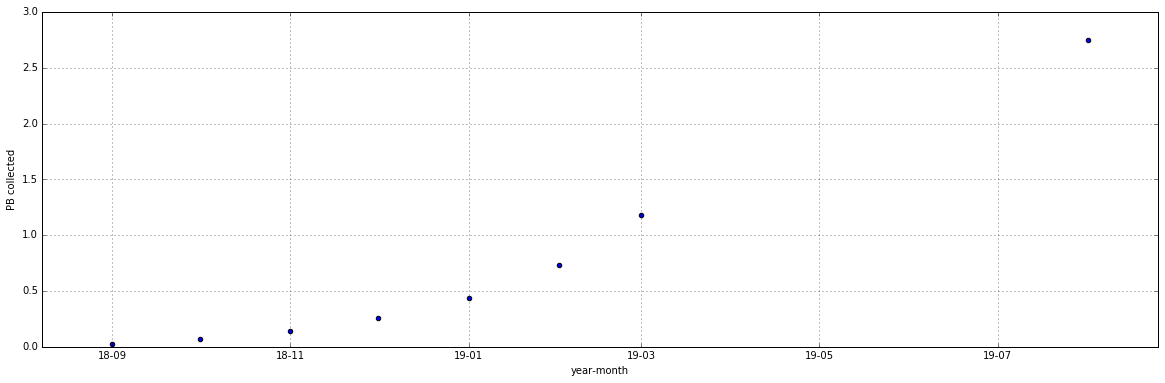

In [17]:
fig, axis = plt.subplots()
axis.scatter(plot_dates, proposed_h2c_cumulative_data_volume)
axis.set_xlabel("year-month")
axis.set_ylabel("PB collected")
axis.set_ylim(ymin=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

Now redo calculation without fringe stopping but with 4096 channels

In [18]:
# This is the max number of channels that Jack can do 'easily'
n_channels = 4096
corr_chan_width = (250 * units.MHz) / n_channels
# Since we will integrate longer after fringe stopping, there's no need to integrate more here
corr_integration_time = 10 * units.s
# no fringe stopping, so use same integration time
corr_post_fringe_stop_int_time = corr_integration_time

channels_to_keep = n_channels * 3.0/4.0
obs_hrs_per_day=(12 * units.hour / units.day)
days_per_month=(30 * units.day)

In [19]:
no_fs_4096_decorrelations_90 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                           corr_FoV=Angle(90., units.degree),
                                           n_channels=n_channels, chan_width=corr_chan_width,
                                           integration_time=corr_integration_time,
                                           fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                           verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.06658529  0.07102448  0.10653776  0.10653776  0.23083324  0.23083324
  0.26190704  0.53269281]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
164.44890392341333 m
Decorrelation due to channel width for a 90.0 degree correlator FoV for the longest baseline
[ 0.02229325  0.02377947  0.03566921  0.03566921  0.07728328  0.07728328
  0.0876868   0.17834604]
Longest baseline for a 90.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
491.17996318720003 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s'
 '90d00m00s' '34d06m17.1197s']
Decorrelation due to time integrating after fringe stopping for a 90.0 degree correlator FoV for the
longest baseline
[ 0.03401616  0.03628399  0.05442652  0.05442652  0.11792484  0.11792484
  0.13379939  0.272

In [20]:
no_fs_4096_decorrelations_10 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                           corr_FoV=Angle(10., units.degree),
                                           n_channels=n_channels, chan_width=corr_chan_width,
                                           integration_time=corr_integration_time,
                                           fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                           verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.06658529  0.07102448  0.10653776  0.10653776  0.23083324  0.23083324
  0.26190704  0.53269281]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
164.44890392341333 m
Decorrelation due to channel width for a 10.0 degree correlator FoV for the longest baseline
[ 0.00387118  0.00412926  0.00619389  0.00619389  0.0134201   0.0134201
  0.01522665  0.03096946]
Longest baseline for a 10.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
2828.5926739140245 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s'
 '90d00m00s' '34d06m17.1197s']
Decorrelation due to time integrating after fringe stopping for a 10.0 degree correlator FoV for the
longest baseline
[ 0.00590684  0.00630065  0.00945107  0.00945107  0.02047743  0.02047743
  0.02323402  0.0472

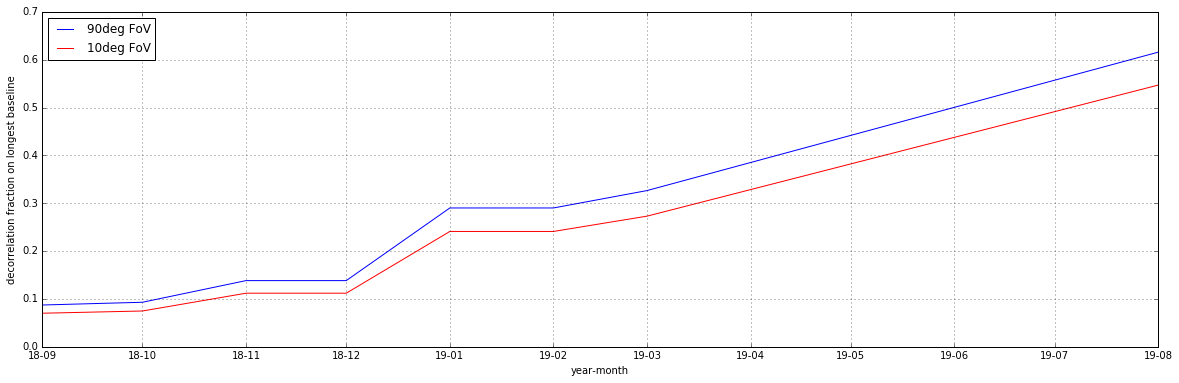

In [21]:
no_fs_4096_total_decorr_90 = no_fs_4096_decorrelations_90['pre_fs_total_decorr']
no_fs_4096_total_decorr_10 = no_fs_4096_decorrelations_10['pre_fs_total_decorr']

fig, axis = plt.subplots()
axis.plot(plot_dates, no_fs_4096_total_decorr_90, label='90deg FoV')
axis.plot(plot_dates, no_fs_4096_total_decorr_10, color='r', label='10deg FoV')
axis.set_xlabel("year-month")
axis.set_ylabel("decorrelation fraction on longest baseline")
axis.legend(loc=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

In [22]:
rates = spec_calcs.data_rates(integration_time=corr_integration_time,
                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                              n_antennas=n_ants, n_channels=channels_to_keep)
print('Naive (correlator internal):')
print('data rate: ', rates[0].to(units.Gbyte/units.s))
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_integration_time)
print('')
print('post fringe stopping:')
print('data rate: ', rates[1].to(units.Gbyte/units.s))
month_data_vol = (rates[1].to(units.Pbyte / units.hour) * obs_hrs_per_day * days_per_month)
print('data volume per month: ', month_data_vol)
no_fs_4096_cumulative_data_volume = np.cumsum(month_data_vol)
print('cumulative data volume per month: ', no_fs_4096_cumulative_data_volume)
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_post_fringe_stop_int_time)

Naive (correlator internal):
data rate:  [ 0.02217738  0.03479962  0.050253    0.08965325  0.14273741  0.22861578
  0.34559754  1.20766464] Gbyte / s
channel width:  61.03515625 kHz
integration time:  10.0 s

post fringe stopping:
data rate:  [ 0.02217738  0.03479962  0.050253    0.08965325  0.14273741  0.22861578
  0.34559754  1.20766464] Gbyte / s
data volume per month:  [ 0.02874189  0.0451003   0.06512789  0.11619061  0.18498768  0.29628605
  0.44789441  1.56513337] Pbyte
cumulative data volume per month:  [ 0.02874189  0.07384219  0.13897008  0.25516069  0.44014837  0.73643443
  1.18432884  2.74946222] Pbyte
channel width:  61.03515625 kHz
integration time:  10.0 s


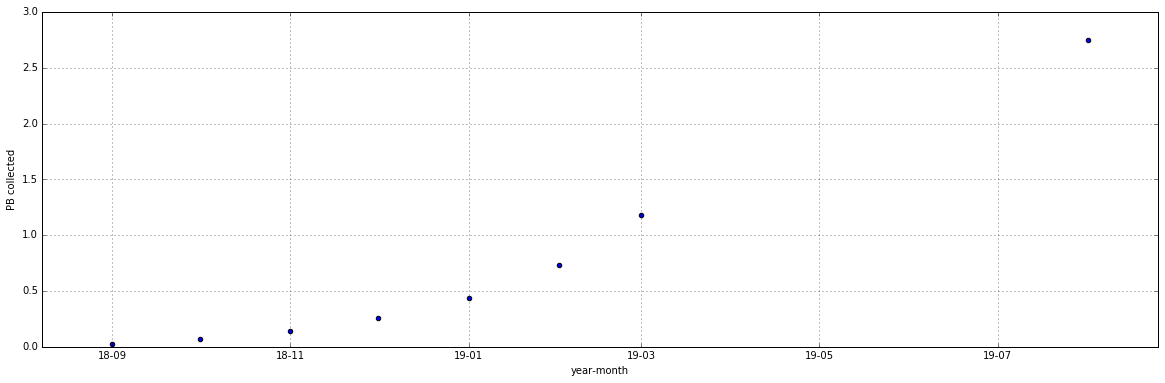

In [23]:
fig, axis = plt.subplots()
axis.scatter(plot_dates, no_fs_4096_cumulative_data_volume)
axis.set_xlabel("year-month")
axis.set_ylabel("PB collected")
axis.set_ylim(ymin=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

Now redo calculation with fringe stopping but with 2048 channels

In [24]:
n_channels = 2048
corr_chan_width = (250 * units.MHz) / n_channels
# Since we will integrate longer after fringe stopping, there's no need to integrate more here
corr_integration_time = .1 * units.s
corr_post_fringe_stop_int_time = 10 * units.s

channels_to_keep = n_channels * 3.0/4.0
obs_hrs_per_day=(12 * units.hour / units.day)
days_per_month=(30 * units.day)

In [25]:
fs_2048_decorrelations_90 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                           corr_FoV=Angle(90., units.degree),
                                           n_channels=n_channels, chan_width=corr_chan_width,
                                           integration_time=corr_integration_time,
                                           fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                           verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.00066585  0.00071024  0.00106538  0.00106538  0.00230833  0.00230833
  0.00261907  0.00532693]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
16444.74466458891 m
Decorrelation due to channel width for a 90.0 degree correlator FoV for the longest baseline
[ 0.04458651  0.04755894  0.07133841  0.07133841  0.15456657  0.15456657
  0.1753736   0.35669207]
Longest baseline for a 90.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
245.58998159360002 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '40d18m48.8666s'
 '40d18m48.8666s' '34d45m53.8472s' '16d16m52.7712s']
Decorrelation due to time integrating after fringe stopping for a 90.0 degree correlator FoV for the
longest baseline
[ 0.03401616  0.03628399  0.05442652  0.05442652  0.11792484  0.11792484
  0.1

In [26]:
fs_2048_decorrelations_10 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                           corr_FoV=Angle(10., units.degree),
                                           n_channels=n_channels, chan_width=corr_chan_width,
                                           integration_time=corr_integration_time,
                                           fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                           verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.00066585  0.00071024  0.00106538  0.00106538  0.00230833  0.00230833
  0.00261907  0.00532693]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
16444.74466458891 m
Decorrelation due to channel width for a 10.0 degree correlator FoV for the longest baseline
[ 0.00774237  0.00825852  0.01238779  0.01238779  0.0268402   0.0268402
  0.03045331  0.06193893]
Longest baseline for a 10.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
1414.2963369570123 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '40d18m48.8666s'
 '40d18m48.8666s' '34d45m53.8472s' '16d16m52.7712s']
Decorrelation due to time integrating after fringe stopping for a 10.0 degree correlator FoV for the
longest baseline
[ 0.00590684  0.00630065  0.00945107  0.00945107  0.02047743  0.02047743
  0.02

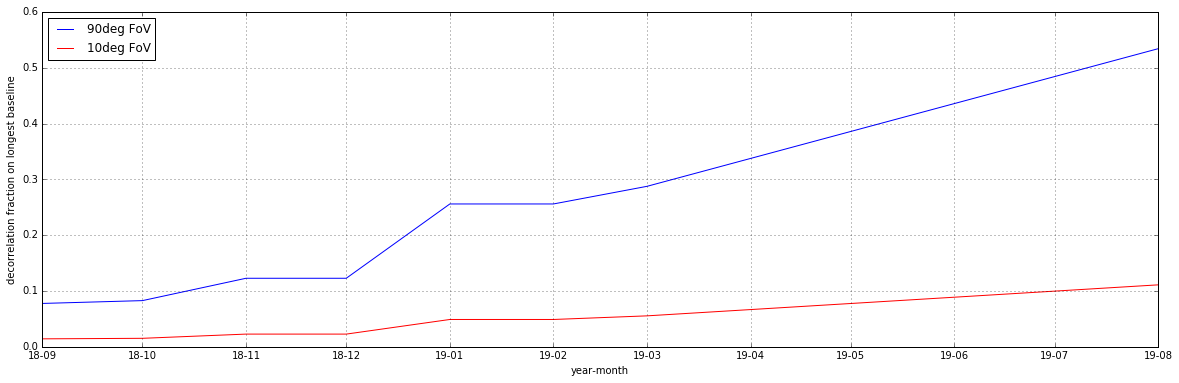

In [27]:
fs_2048_total_decorr_90 = fs_2048_decorrelations_90['post_fs_total_decorr']
fs_2048_total_decorr_10 = fs_2048_decorrelations_10['post_fs_total_decorr']

fig, axis = plt.subplots()
axis.plot(plot_dates, fs_2048_total_decorr_90, label='90deg FoV')
axis.plot(plot_dates, fs_2048_total_decorr_10, color='r', label='10deg FoV')
axis.set_xlabel("year-month")
axis.set_ylabel("decorrelation fraction on longest baseline")
axis.legend(loc=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

In [28]:
rates = spec_calcs.data_rates(integration_time=corr_integration_time,
                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                              n_antennas=n_ants, n_channels=channels_to_keep)
print('Naive (correlator internal):')
print('data rate: ', rates[0].to(units.Gbyte/units.s))
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_integration_time)
print('')
print('post fringe stopping:')
print('data rate: ', rates[1].to(units.Gbyte/units.s))
month_data_vol = (rates[1].to(units.Pbyte / units.hour) * obs_hrs_per_day * days_per_month)
print('data volume per month: ', month_data_vol)
fs_2048_cumulative_data_volume = np.cumsum(month_data_vol)
print('cumulative data volume per month: ', fs_2048_cumulative_data_volume)
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_post_fringe_stop_int_time)

Naive (correlator internal):
data rate:  [  1.10886912   1.7399808    2.51265024   4.4826624    7.1368704
  11.43078912  17.27987712  60.383232  ] Gbyte / s
channel width:  122.0703125 kHz
integration time:  0.1 s

post fringe stopping:
data rate:  [ 0.01108869  0.01739981  0.0251265   0.04482662  0.0713687   0.11430789
  0.17279877  0.60383232] Gbyte / s
data volume per month:  [ 0.01437094  0.02255015  0.03256395  0.0580953   0.09249384  0.14814303
  0.22394721  0.78256669] Pbyte
cumulative data volume per month:  [ 0.01437094  0.03692109  0.06948504  0.12758035  0.22007419  0.36821721
  0.59216442  1.37473111] Pbyte
channel width:  122.0703125 kHz
integration time:  10.0 s


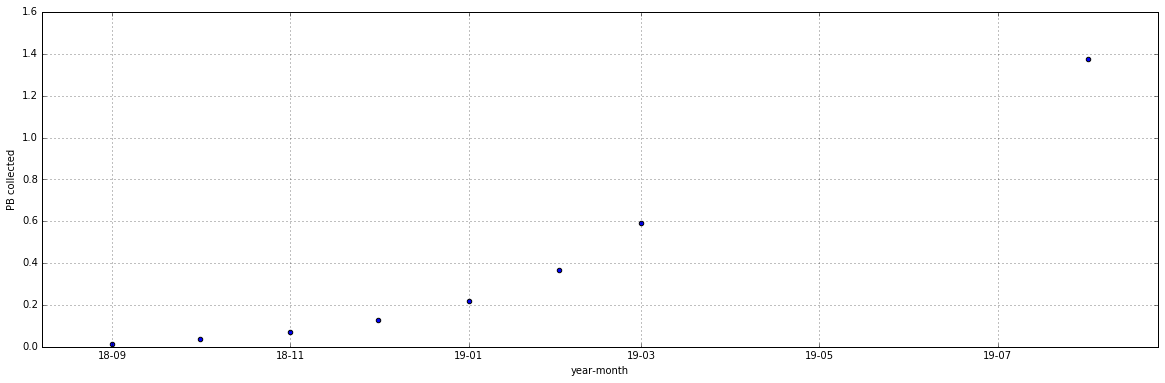

In [29]:
fig, axis = plt.subplots()
axis.scatter(plot_dates, fs_2048_cumulative_data_volume)
axis.set_xlabel("year-month")
axis.set_ylabel("PB collected")
axis.set_ylim(ymin=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

Now redo calculation without fringe stopping but with 2048 channels

In [30]:
# This is the max number of channels that Jack can do 'easily'
n_channels = 2048
corr_chan_width = (250 * units.MHz) / n_channels
# Since we will integrate longer after fringe stopping, there's no need to integrate more here
corr_integration_time = 10. * units.s
# no fringe stopping, so use same integration time
corr_post_fringe_stop_int_time = corr_integration_time

channels_to_keep = n_channels * 3.0/4.0
obs_hrs_per_day=(12 * units.hour / units.day)
days_per_month=(30 * units.day)

In [31]:
current_decorrelations_90 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                           corr_FoV=Angle(90., units.degree),
                                           n_channels=n_channels, chan_width=corr_chan_width,
                                           integration_time=corr_integration_time,
                                           fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                           verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.06658529  0.07102448  0.10653776  0.10653776  0.23083324  0.23083324
  0.26190704  0.53269281]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
164.44890392341333 m
Decorrelation due to channel width for a 90.0 degree correlator FoV for the longest baseline
[ 0.04458651  0.04755894  0.07133841  0.07133841  0.15456657  0.15456657
  0.1753736   0.35669207]
Longest baseline for a 90.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
245.58998159360002 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '40d18m48.8666s'
 '40d18m48.8666s' '34d45m53.8472s' '16d16m52.7712s']
Decorrelation due to time integrating after fringe stopping for a 90.0 degree correlator FoV for the
longest baseline
[ 0.03401616  0.03628399  0.05442652  0.05442652  0.11792484  0.11792484
  0.

In [32]:
current_decorrelations_10 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                           corr_FoV=Angle(10., units.degree),
                                           n_channels=n_channels, chan_width=corr_chan_width,
                                           integration_time=corr_integration_time,
                                           fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                           verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.06658529  0.07102448  0.10653776  0.10653776  0.23083324  0.23083324
  0.26190704  0.53269281]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
164.44890392341333 m
Decorrelation due to channel width for a 10.0 degree correlator FoV for the longest baseline
[ 0.00774237  0.00825852  0.01238779  0.01238779  0.0268402   0.0268402
  0.03045331  0.06193893]
Longest baseline for a 10.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
1414.2963369570123 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '40d18m48.8666s'
 '40d18m48.8666s' '34d45m53.8472s' '16d16m52.7712s']
Decorrelation due to time integrating after fringe stopping for a 10.0 degree correlator FoV for the
longest baseline
[ 0.00590684  0.00630065  0.00945107  0.00945107  0.02047743  0.02047743
  0.0

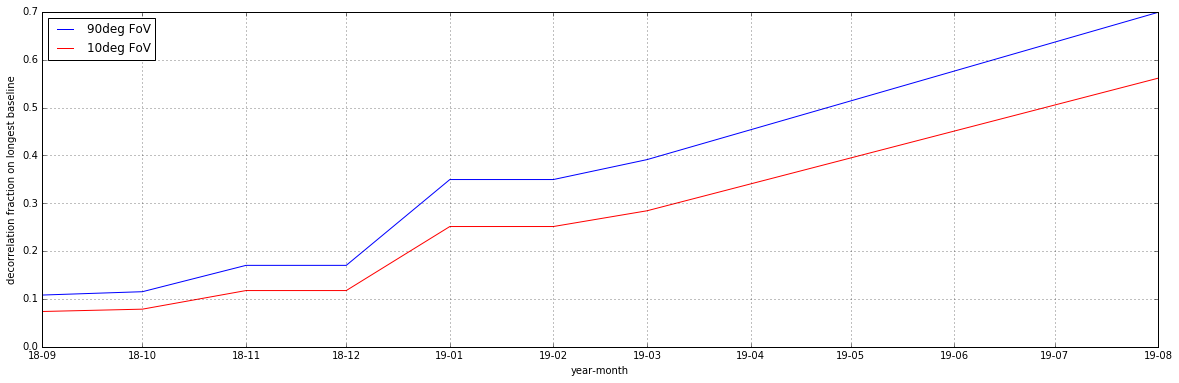

In [33]:
current_total_decorr_90 = current_decorrelations_90['pre_fs_total_decorr']
current_total_decorr_10 = current_decorrelations_10['pre_fs_total_decorr']

fig, axis = plt.subplots()
axis.plot(plot_dates, current_total_decorr_90, label='90deg FoV')
axis.plot(plot_dates, current_total_decorr_10, color='r', label='10deg FoV')
axis.set_xlabel("year-month")
axis.set_ylabel("decorrelation fraction on longest baseline")
axis.legend(loc=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

In [34]:
rates = spec_calcs.data_rates(integration_time=corr_integration_time,
                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                              n_antennas=n_ants, n_channels=channels_to_keep)
print('Naive (correlator internal):')
print('data rate: ', rates[0].to(units.Gbyte/units.s))
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_integration_time)
print('')
print('post fringe stopping:')
print('data rate: ', rates[1].to(units.Gbyte/units.s))
month_data_vol = (rates[1].to(units.Pbyte / units.hour) * obs_hrs_per_day * days_per_month)
print('data volume per month: ', month_data_vol)
current_cumulative_data_volume = np.cumsum(month_data_vol)
print('cumulative data volume per month: ', current_cumulative_data_volume)
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_post_fringe_stop_int_time)

Naive (correlator internal):
data rate:  [ 0.01108869  0.01739981  0.0251265   0.04482662  0.0713687   0.11430789
  0.17279877  0.60383232] Gbyte / s
channel width:  122.0703125 kHz
integration time:  10.0 s

post fringe stopping:
data rate:  [ 0.01108869  0.01739981  0.0251265   0.04482662  0.0713687   0.11430789
  0.17279877  0.60383232] Gbyte / s
data volume per month:  [ 0.01437094  0.02255015  0.03256395  0.0580953   0.09249384  0.14814303
  0.22394721  0.78256669] Pbyte
cumulative data volume per month:  [ 0.01437094  0.03692109  0.06948504  0.12758035  0.22007419  0.36821721
  0.59216442  1.37473111] Pbyte
channel width:  122.0703125 kHz
integration time:  10.0 s


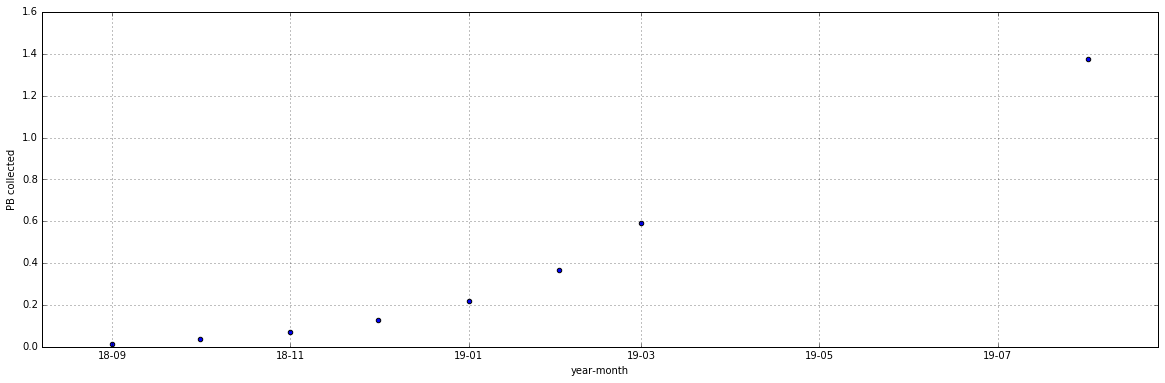

In [35]:
fig, axis = plt.subplots()
axis.scatter(plot_dates, current_cumulative_data_volume)
axis.set_xlabel("year-month")
axis.set_ylabel("PB collected")
axis.set_ylim(ymin=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

Finally, do calculation for optimal 350 design (8192 channels with 2s fringe stopping)

In [36]:
# This is the max number of channels that Jack can do 'easily'
n_channels = 8192
corr_chan_width = (250 * units.MHz) / n_channels
# Since we will integrate longer after fringe stopping, there's no need to integrate more here
corr_integration_time = .1 * units.s
# after fringe stopping, we can sum in time to longer integrations
corr_post_fringe_stop_int_time = 2 * units.s

channels_to_keep = n_channels * 3.0/4.0
obs_hrs_per_day=(12 * units.hour / units.day)
days_per_month=(30 * units.day)

In [37]:
proposed_h3c_decorrelations_90 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                              corr_FoV=Angle(90., units.degree),
                                              n_channels=n_channels, chan_width=corr_chan_width,
                                              integration_time=corr_integration_time,
                                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                              verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.00066585  0.00071024  0.00106538  0.00106538  0.00230833  0.00230833
  0.00261907  0.00532693]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
16444.74466458891 m
Decorrelation due to channel width for a 90.0 degree correlator FoV for the longest baseline
[ 0.01114663  0.01188974  0.0178346   0.0178346   0.03864164  0.03864164
  0.0438434   0.08917302]
Longest baseline for a 90.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
982.3599263744001 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s'
 '90d00m00s' '90d00m00s']
Decorrelation due to time integrating after fringe stopping for a 90.0 degree correlator FoV for the
longest baseline
[ 0.00680323  0.0072568   0.0108853   0.0108853   0.02358497  0.02358497
  0.02675988  0.05442692]


In [38]:
proposed_h3c_decorrelations_10 = spec_calcs.decorrelations(baseline=max_baseline_m,
                                              corr_FoV=Angle(10., units.degree),
                                              n_channels=n_channels, chan_width=corr_chan_width,
                                              integration_time=corr_integration_time,
                                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                                              verbose=True)

Decorrelation fraction due to integration time on the longest baseline
[ 0.00066585  0.00071024  0.00106538  0.00106538  0.00230833  0.00230833
  0.00261907  0.00532693]
Longest E-W baseline with less than 10.0% decorrelation due to integration time
16444.74466458891 m
Decorrelation due to channel width for a 10.0 degree correlator FoV for the longest baseline
[ 0.00193559  0.00206463  0.00309695  0.00309695  0.00671005  0.00671005
  0.00761333  0.01548473]
Longest baseline for a 10.0 degree correlator FoV with less than 10.0% decorrelation due to channel
width
5657.185347828049 m
Correlator FoV with less than 10.0% decorrelation due to channel width for the longest baseline
['90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s' '90d00m00s'
 '90d00m00s' '90d00m00s']
Decorrelation due to time integrating after fringe stopping for a 10.0 degree correlator FoV for the
longest baseline
[ 0.00118137  0.00126013  0.00189021  0.00189021  0.00409549  0.00409549
  0.0046468   0.00945114]


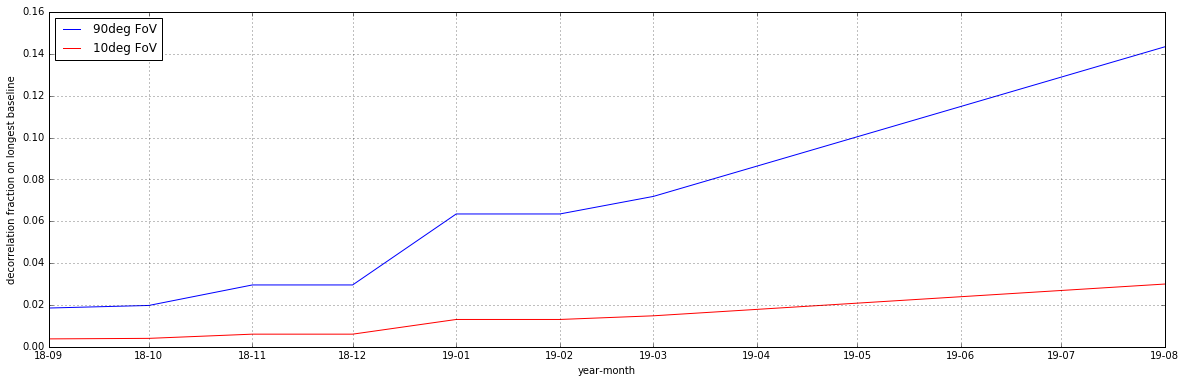

In [39]:
proposed_h3c_total_decorr_90 = proposed_h3c_decorrelations_90['post_fs_total_decorr']
proposed_h3c_total_decorr_10 = proposed_h3c_decorrelations_10['post_fs_total_decorr']

fig, axis = plt.subplots()
axis.plot(plot_dates, proposed_h3c_total_decorr_90, label='90deg FoV')
axis.plot(plot_dates, proposed_h3c_total_decorr_10, color='r', label='10deg FoV')
axis.set_xlabel("year-month")
axis.set_ylabel("decorrelation fraction on longest baseline")
axis.legend(loc=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

In [40]:
rates = spec_calcs.data_rates(integration_time=corr_integration_time,
                              fringe_stop_int_time=corr_post_fringe_stop_int_time,
                              n_antennas=n_ants, n_channels=channels_to_keep)
print('Naive (correlator internal):')
print('data rate: ', rates[0].to(units.Gbyte/units.s))
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_integration_time)
print('')
print('post fringe stopping:')
print('data rate: ', rates[1].to(units.Gbyte/units.s))
month_data_vol = (rates[1].to(units.Pbyte / units.hour) * obs_hrs_per_day * days_per_month)
print('data volume per month: ', month_data_vol)
proposed_h3c_cumulative_data_volume = np.cumsum(month_data_vol)
print('cumulative data volume per month: ', proposed_h3c_cumulative_data_volume)
print('channel width: ', corr_chan_width.to(units.kHz))
print('integration time: ', corr_post_fringe_stop_int_time)

Naive (correlator internal):
data rate:  [   4.43547648    6.9599232    10.05060096   17.9306496    28.5474816
   45.72315648   69.11950848  241.532928  ] Gbyte / s
channel width:  30.517578125 kHz
integration time:  0.1 s

post fringe stopping:
data rate:  [  0.22177382   0.34799616   0.50253005   0.89653248   1.42737408
   2.28615782   3.45597542  12.0766464 ] Gbyte / s
data volume per month:  [  0.28741888   0.45100302   0.65127894   1.16190609   1.84987681
   2.96286054   4.47894415  15.65133373] Pbyte
cumulative data volume per month:  [  0.28741888   0.7384219    1.38970084   2.55160694   4.40148374
   7.36434428  11.84328843  27.49462217] Pbyte
channel width:  30.517578125 kHz
integration time:  2.0 s


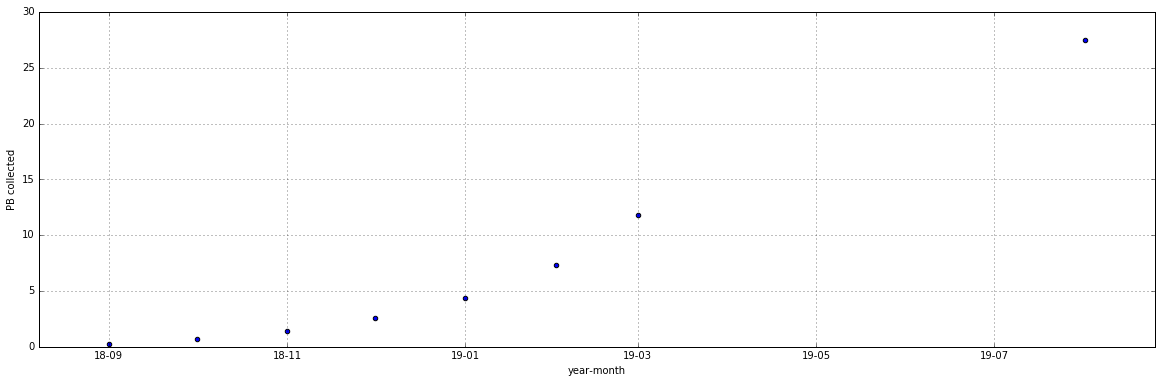

In [41]:
fig, axis = plt.subplots()
axis.scatter(plot_dates, proposed_h3c_cumulative_data_volume)
axis.set_xlabel("year-month")
axis.set_ylabel("PB collected")
axis.set_ylim(ymin=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

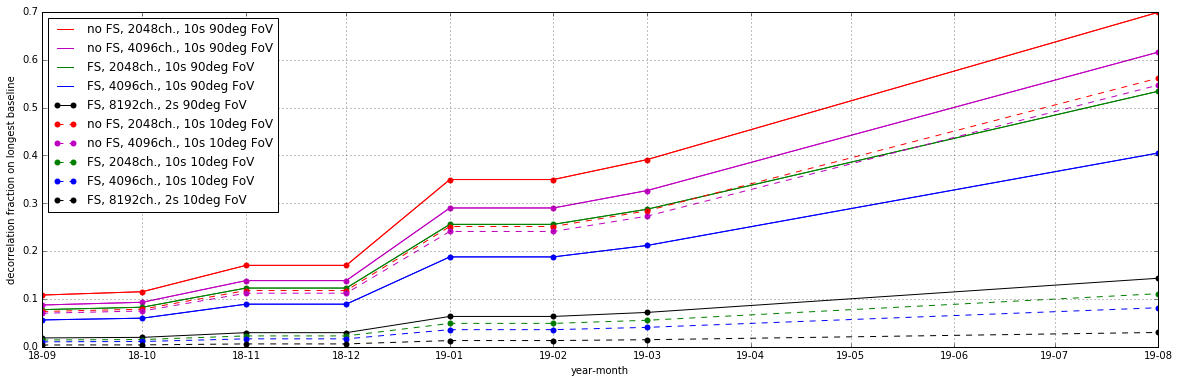

In [70]:
from matplotlib.legend_handler import HandlerLine2D

fig, axis = plt.subplots()
axis.plot(plot_dates, current_total_decorr_90, color='r', marker='o', markeredgewidth=0)
axis.plot(plot_dates, current_total_decorr_90, color='r', label='no FS, 2048ch., 10s 90deg FoV')

axis.plot(plot_dates, no_fs_4096_total_decorr_90, color='m', marker='o', markeredgewidth=0)
axis.plot(plot_dates, no_fs_4096_total_decorr_90, color='m', label='no FS, 4096ch., 10s 90deg FoV')

axis.plot(plot_dates, fs_2048_total_decorr_90, color='g', marker='o', markeredgewidth=0)
axis.plot(plot_dates, fs_2048_total_decorr_90, color='g', label='FS, 2048ch., 10s 90deg FoV')

axis.plot(plot_dates, proposed_h2c_total_decorr_90, color='b', marker='o', markeredgewidth=0)
axis.plot(plot_dates, proposed_h2c_total_decorr_90, color='b', label='FS, 4096ch., 10s 90deg FoV')

axis.plot(plot_dates, proposed_h3c_total_decorr_90, color='black', marker='o', markeredgewidth=0)
axis.plot(plot_dates, proposed_h3c_total_decorr_90, color='black', label='FS, 8192ch., 2s 90deg FoV')

axis.plot(plot_dates, current_total_decorr_10, color='r', linestyle='--', marker='o', markeredgewidth=0)
axis.plot(plot_dates, current_total_decorr_10, color='r', label='no FS, 2048ch., 10s 10deg FoV', linestyle='--')

axis.plot(plot_dates, no_fs_4096_total_decorr_10, color='m', linestyle='--', marker='o', markeredgewidth=0)
axis.plot(plot_dates, no_fs_4096_total_decorr_10, color='m', label='no FS, 4096ch., 10s 10deg FoV', linestyle='--')

axis.plot(plot_dates, fs_2048_total_decorr_10, color='g', label='FS, 2048ch., 10s 10deg FoV', linestyle='--', marker='o', markeredgewidth=0)
axis.plot(plot_dates, fs_2048_total_decorr_10, color='g', label='FS, 2048ch., 10s 10deg FoV', linestyle='--', marker='o', markeredgewidth=0)

axis.plot(plot_dates, proposed_h2c_total_decorr_10, color='b', label='FS, 4096ch., 10s 10deg FoV', linestyle='--', marker='o', markeredgewidth=0)
axis.plot(plot_dates, proposed_h2c_total_decorr_10, color='b', label='FS, 4096ch., 10s 10deg FoV', linestyle='--', marker='o', markeredgewidth=0)

axis.plot(plot_dates, proposed_h3c_total_decorr_10, color='black', label='FS, 8192ch., 2s 10deg FoV', linestyle='--', marker='o', markeredgewidth=0)
axis.plot(plot_dates, proposed_h3c_total_decorr_10, color='black', label='FS, 8192ch., 2s 10deg FoV', linestyle='--', marker='o', markeredgewidth=0)

axis.set_xlabel("year-month")
axis.set_ylabel("decorrelation fraction on longest baseline")
axis.legend(loc=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

fig.savefig('decorrelation.png', bbox_inches='tight')

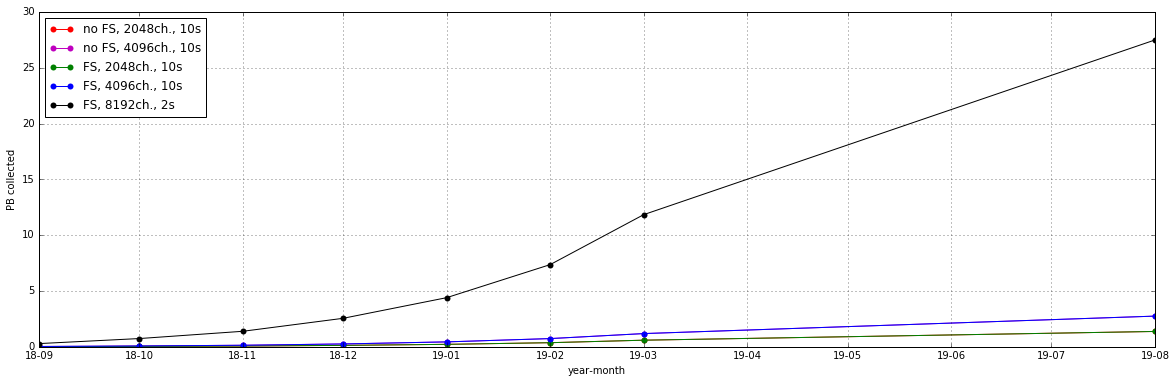

In [43]:
fig, axis = plt.subplots()
axis.plot(plot_dates, current_cumulative_data_volume, color='r', label='no FS, 2048ch., 10s', marker='o', markeredgewidth=0)
axis.plot(plot_dates, no_fs_4096_cumulative_data_volume, color='m', label='no FS, 4096ch., 10s', marker='o', markeredgewidth=0)
axis.plot(plot_dates, fs_2048_cumulative_data_volume, color='g', label='FS, 2048ch., 10s', marker='o', markeredgewidth=0)
axis.plot(plot_dates, proposed_h2c_cumulative_data_volume, color='b', label='FS, 4096ch., 10s', marker='o', markeredgewidth=0)
axis.plot(plot_dates, proposed_h3c_cumulative_data_volume, color='black', label='FS, 8192ch., 2s', marker='o', markeredgewidth=0)
axis.set_xlabel("year-month")
axis.set_ylabel("PB collected")
axis.legend(loc=0)
axis.set_ylim(ymin=0)
axis.grid()
axis.xaxis.set_major_formatter(month_format)

fig.savefig('data_rate.png', bbox_inches='tight')